In this notebook, we'll create a framework for image classification in Tensorflow.

This code should be replicable to any image task with a few changes.

Our specific task will be to classify images of traffic lights as red, yellow, or green.

In [180]:
#!/usr/bin/python2

%matplotlib inline

import sys, os, time
import itertools
import math, random
import glob
import tensorflow as tf
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

First, we set some basic parameters:

    base_image_path: the path where our training data is stored
    
    image_types: subdirectories in the images folder, each one representing a different class
    
    input_img_x/y: width and height of the images
    
    train_test_split_ratio: the ratio of training images to testing images
    
    batch_size: the minibatch size
    
    checkpoint_name: where we will save our best model
    

In [181]:
# Basic parameters

max_epochs = 25
base_image_path = "5_tensorflow_traffic_light_images/"
image_types = ["red", "green", "yellow"]
input_img_x = 32
input_img_y = 32
train_test_split_ratio = 0.9
batch_size = 32
checkpoint_name = "model.ckpt"

In [182]:
# Helper layer functions
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


Here we initialize our input and output neurons.

Our input neurons will be the shape of the image which is (32 x 32 x 3)

Because our data will be one-hot encoded, we have as many output neurons as we have classes

In [183]:
# Model

x = tf.placeholder(tf.float32, shape=[None, input_img_x, input_img_y, 3])
y_ = tf.placeholder(tf.float32, shape=[None, len(image_types)])

This is where we specify our first convolutional layers.

We specify the number of weights in the first line:

    W_conv1 = weight_variable([3, 3, 3, 16])
    
This line is for specifying the number of bias variables, or the variables that will be added to weights after multiplying them by the activation.

    b_conv1 = bias_variable([16])
    
Next, we specify the activation:

    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 1) + b_conv1)

In [184]:
# Model - THIS PART SHOULD BE SAVED SEPARATELY IN "model.txt" file, SO IT CAN BE RETRIEVED AUTOMATICALLY BY "ranking.ipynb"
    
# ed: 꼭 model.txt 파일을 사용해야하고 이름을 바꾸면 안된다!

x_image = x


# ed: 1층 conv 다음에 바로 max pooling ==> fully connected layer로 이어지도록 구성되어 있다

# Our first three convolutional layers, of 16 3x3 filters
W_conv1 = weight_variable([3, 3, 3, 16])
b_conv1 = bias_variable([16])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 1) + b_conv1)

# Our pooling layer

h_pool4 = max_pool_2x2(h_conv1)

n1, n2, n3, n4 = h_pool4.get_shape().as_list()

W_fc1 = weight_variable([n2*n3*n4, 3])
b_fc1 = bias_variable([3])

# We flatten our pool layer into a fully connected layer

h_pool4_flat = tf.reshape(h_pool4, [-1, n2*n3*n4])

y = tf.matmul(h_pool4_flat, W_fc1) + b_fc1


# ed: Dictionary 형식으로 가중치를 저장하는 코드 (아직은 저장 안하고 저장하도록 설정만 함)
saver = tf.train.Saver({'W_conv1' : W_conv1, 'b_conv1' : b_conv1, 'W_fc1' : W_fc1, 'b_fc1' : b_fc1})

In [185]:
sess = tf.InteractiveSession()

Our loss function is defined as computing softmax, and then cross entropy.

We also specify our optimizer, which takes a learning rate, and a loss function.

Finally, we initialize all of our variables which will tell us if our model is valid.

In [186]:
# Our loss function and optimizer

# ed: loss func, optimizer 변경하고 싶으면 변경하면 된다
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y_, logits = y))
train_step = tf.train.AdamOptimizer(1e-4, 0.9).minimize(loss)
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


We need to load in our images.  We do so using OpenCV's imread function.  After loading in each image, we resize it to our input size.

With each loaded image, we also specify the expected output.  For this, we use a one-hot encoding, creating an array of zeros represnting each class, and setting the index of the expected class number to 1.

For example, if we have three classes, and we expect an order of: [red neuron, green neuron, yellow neuron]

We initialize an array to [0, 0, 0] and if we loaded a yellow light, we change the last value to 1: [0, 0, 1]

Finally, we shuffle our dataset.  (It's generally useful to seed our random generator with 0 at the start of the program)

In [187]:
v_loss = least_loss = 99999999

# Load data

full_set = []

# ed: Train set, Test set을 나누는 코드
for im_type in image_types:
    for ex in glob.glob(os.path.join(base_image_path, im_type, "*")):
        im = cv2.imread(ex)
        if not im is None:
            im = cv2.resize(im, (32, 32))

            # Create an array representing our classes and set it
            one_hot_array = [0] * len(image_types)
            one_hot_array[image_types.index(im_type)] = 1

            assert(im.shape == (32, 32, 3))

            full_set.append((im, one_hot_array, ex))

random.shuffle(full_set)


Using our train_test_split_ratio we create two lists of examples: testing and training.

In [188]:
# We split our data into a training and test set here

split_index = int(math.floor(len(full_set) * train_test_split_ratio))
train_set = full_set[:split_index]
test_set = full_set[split_index:]

# We ensure that our training and test sets are a multiple of batch size
train_set_offset = len(train_set) % batch_size
test_set_offset = len(test_set) % batch_size
train_set = train_set[: len(train_set) - train_set_offset]
test_set = test_set[: len(test_set) - test_set_offset]

train_x, train_y, train_z = zip(*train_set)
test_x, test_y, test_z = zip(*test_set)

Every time we iterate over all of our training examples, we have completed one epoch.  Generally, we should start with one epoch while debugging, and in practice many datasets will converge with less than 100 epochs.  It's something that needs to be explored with each dataset.

We split our training set into batches, which we train on in order.

We then use our entire datset to calculate training and validation loss.  These are the values we want to minimize, but it's important to pay attention to the interaction between them.  If training loss is going down, but validation is staying the same, it means we are overfitting our dataset: our network is becoming increasingly good at correctly classifying our training examples, but our network isn't generalizing to other examples outside the training set.

We save our model if the current model has the lowest validation seen in this training run.

In [189]:
print("Starting training... [{} training examples]".format(len(train_x)))

v_loss = 9999999
train_loss = []
val_loss = []

for i in range(0, max_epochs):

    # Iterate over our training set
    for tt in range(0, (len(train_x) // batch_size)):
        start_batch = batch_size * tt
        end_batch = batch_size * (tt + 1)
        train_step.run(feed_dict={x: train_x[start_batch:end_batch], y_: train_y[start_batch:end_batch]})
        ex_seen = "Current epoch, examples seen: {:20} / {} \r".format(tt * batch_size, len(train_x))
        sys.stdout.write(ex_seen.format(tt * batch_size))
        sys.stdout.flush()

    ex_seen = "Current epoch, examples seen: {:20} / {} \r".format((tt + 1) * batch_size, len(train_x))
    sys.stdout.write(ex_seen.format(tt * batch_size))
    sys.stdout.flush()

    t_loss = loss.eval(feed_dict={x: train_x, y_: train_y})
    v_loss = loss.eval(feed_dict={x: test_x, y_: test_y})
    
    train_loss.append(t_loss)
    val_loss.append(v_loss)

    sys.stdout.write("Epoch {:5}: loss: {:15.10f}, val. loss: {:15.10f}".format(i + 1, t_loss, v_loss))

    # ed: v_loss가 제일 낮을 경우에만 파라미터를 저장한다
    if v_loss < least_loss:
        sys.stdout.write(", saving new best model to {}".format(checkpoint_name))
        least_loss = v_loss
        filename = saver.save(sess, checkpoint_name)

    sys.stdout.write("\n")

Starting training... [1312 training examples]
Epoch     1: loss:   40.1968536377, val. loss:   46.4278526306, saving new best model to model.ckpt
Epoch     2: loss:   24.5146217346, val. loss:   29.1402015686, saving new best model to model.ckpt
Epoch     3: loss:   17.7827186584, val. loss:   20.5537929535, saving new best model to model.ckpt
Epoch     4: loss:   13.8622894287, val. loss:   16.2608947754, saving new best model to model.ckpt
Epoch     5: loss:   11.2865381241, val. loss:   13.0651226044, saving new best model to model.ckpt
Epoch     6: loss:    9.4941082001, val. loss:   10.6800231934, saving new best model to model.ckpt
Epoch     7: loss:    8.0474061966, val. loss:    9.0067873001, saving new best model to model.ckpt
Epoch     8: loss:    6.7782025337, val. loss:    7.5996441841, saving new best model to model.ckpt
Epoch     9: loss:    5.6428527832, val. loss:    6.0413303375, saving new best model to model.ckpt
Epoch    10: loss:    4.6634254456, val. loss:    4.96

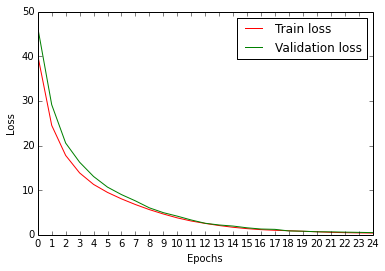

In [190]:
# ed: 윗부분까지가 사실상 끝난 것이다. 아랫부분은 analyze 부분

plt.figure()
plt.xticks(np.arange(0, len(train_loss), 1.0))
plt.ylabel("Loss")
plt.xlabel("Epochs")
train_line = plt.plot(range(0, len(train_loss)), train_loss, 'r', label="Train loss")
val_line = plt.plot(range(0, len(val_loss)), val_loss, 'g', label="Validation loss")
plt.legend()
plt.show()

Let's print the examples from our test set that were wrong:

Actual: red, predicted: green


Actual: yellow, predicted: green


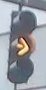

Actual: green, predicted: yellow


In [191]:
zipped_x_y = list(zip(test_x, test_y))
conf_true = []
conf_pred = []
for tt in range(0, len(zipped_x_y)):
    q = zipped_x_y[tt]
    sfmax = list(sess.run(tf.nn.softmax(y.eval(feed_dict={x: [q[0]]})))[0])
    sf_ind = sfmax.index(max(sfmax))
    
    predicted_label = image_types[sf_ind]
    actual_label = image_types[q[1].index(max(q[1]))]
    
    conf_true.append(actual_label)
    conf_pred.append(predicted_label)
    
    if predicted_label != actual_label:
        print("Actual: {}, predicted: {}".format(actual_label, predicted_label))
        img_path = test_z[tt]    
        ex_img = Image(filename=img_path)
        display(ex_img)

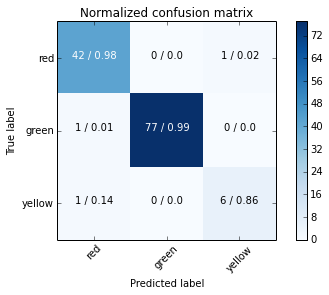

In [192]:
# From sklearn docs
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    cm2 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cm2 = np.around(cm2, 2)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm[i, j]) + " / " + str(cm2[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(conf_true, conf_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=image_types, normalize=False,
                      title='Normalized confusion matrix')
plt.show()